In [338]:
import numpy as np  # for random number generation
import scipy.stats as stats  # for calculating confidence intervals
import math as math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import combinations
np.set_printoptions(suppress=True)

In [339]:
# helper functions

def get_profile(id):
    '''return a dict
 
    given id, return the individual status and information stored in a dictionary
    '''
    profile = {
               'infected': infected[id], 
               'incubation': incubation[id],
               'symptom': symptom[id],
               'age_groups': age_groups[id],
               'dead': dead[id], 
               'cured': cured[id]
              }
    return profile
    
def check_infection(id_list):
    '''return a numpy array
    
    input a list id to check
    return a list of id who have been infected, from the input list
    '''
    return id_list[np.isin(id_list, np.where(infected==1)[0])]

def check_cured(id_list):
    '''return a numpy array
    
    input an array of id to check
    return an array of id who have been cured, from the input list
    '''
    return id_list[np.isin(id_list, np.where(cured==1)[0])]
    
    
def interact(id_list, scenario, label, interaction_rate_choices, verbose=True):
    '''return a list of tuples

    model human interactions
    first generate all possible combinations of choosing a pair from n people (n choose 2)
    second randomly pick a portion of combinations, representing the actual close interactions happened in a single day
    return all pairs of combinations (interactions)
    '''
    if len(id_list) < 2:
        print(f'Less than 2 people left in {scenario}{label}')
        return None
    #n_interactions = int(interaction_rate_choices[scenario]*len(people_index_list))
    possible_combos = list(combinations(id_list, 2))
    n_possible_combos = len(possible_combos)
    n_interactions = int(interaction_rate_choices[scenario]*n_possible_combos)
    
    if n_interactions < 1:
        n_interactions = 1
    
    actual_interactions_index = np.random.choice(a=[i for i in range(n_possible_combos)], size=n_interactions)
    actual_interactions = [possible_combos[i] for i in actual_interactions_index]
    assert len(actual_interactions)==n_interactions, 'length mismatch'
    
    if verbose:
        print(f'People in {scenario}{label}:', id_list, '\n')
        print(f'People infected: {check_infection(id_list)}\n')
        print(f'People infected: {check_cured(id_list)}\n')
        print(f'There are {n_possible_combos} possible combinations of interations\n')
        print(f'There are {n_interactions} actual interactions\n')
        #print(actual_interactions)
    assert len(actual_interactions) > 0, f'{actual_interactions} has no interactions'
    return actual_interactions
    
    
def infect(actual_interactions, verbose=True):
    '''return None
    
    simulate infection taking place among all the actual interactions happened in a day
    newly infected individuals will have their status updated
    '''
    # convert a list of tuples into two numpy arrays
    assert len(list(zip(*actual_interactions))) == 2, f'{list(zip(*actual_interactions))} does not have length of 2'
    person1 = np.array(list(zip(*actual_interactions))[0])
    person2 = np.array(list(zip(*actual_interactions))[1])
    
    # check if the person in the interaction pair has been infected
    person1_infected_bool = np.isin(person1, np.where(infected==1)[0])
    person2_infected_bool = np.isin(person2, np.where(infected==1)[0])
    
    # check if the person in the interaction pair has been cured
    person1_cured_bool = np.isin(person1, np.where(cured==1)[0])
    person2_cured_bool = np.isin(person2, np.where(cured==1)[0])
    
    # find the boolean arrays of dangerous interactions (one person infected, the other not)
    dangerous_interactions_bool = np.not_equal(person1_infected_bool, person2_infected_bool)
    
    assert len(person1_infected_bool)==len(person1_cured_bool)==len(dangerous_interactions_bool), ' person1 length mismatch'
    # find the persons (ID) who are involved in the dangerous interactions 
    # and aren't not infected currently nor were cured before
    person1_dangerous = person1[dangerous_interactions_bool 
                                & np.logical_not(person1_infected_bool)
                                & np.logical_not(person1_cured_bool)]
    person2_dangerous = person2[dangerous_interactions_bool 
                                & np.logical_not(person2_infected_bool)
                                & np.logical_not(person2_cured_bool)]
    
    # combine the two person vectors
    # note that there will be duplicates since the same person can be involved in multiple 
    # dangerous interactions
    person_dangerous = np.r_[person1_dangerous, person2_dangerous]
    
    unique_persons = np.unique(person_dangerous, return_counts=True)[0]
    unique_persons_count = np.unique(person_dangerous, return_counts=True)[1]
    
    newly_infected = []
    
    for i in range(len(unique_persons)):
        age_group = get_profile(id=unique_persons[i])['age_groups']
        infection_prob = infection_prob_choices[age_group]
        if np.random.binomial(unique_persons_count[i], infection_prob) >= 1:
            newly_infected.append(unique_persons[i])
            infected[unique_persons[i]] = 1
            incubation[unique_persons[i]] = 1
    if verbose:
        print(f'Newly infected people: {newly_infected}\n')
        print('-'*100, '\n')

    
        
def incubation_progress_update():
    '''return None
    
    every day, update the number of incubation period by 1 for people under incubation
    '''
    incubation_progress_day[np.where(incubation==1)[0]] += 1
        
def symptom_progress_update():
    '''return None

    every day, update the number of symptoms period by 1 for people who developed symptoms
    '''
    symptom_progress_day[np.where(symptom==1)[0]] += 1
    
def start_symptom(incubation_periods):
    '''return None

    people under under incubation will start develop symptoms in a certain number of days
    '''
    start_symptom_id = np.where(np.equal(incubation_progress_day, incubation_periods))[0]
    symptom[start_symptom_id] = 1
    symptom_progress_day[start_symptom_id] = 1
    
    incubation[start_symptom_id] = 0
    incubation_progress_day[start_symptom_id] = 0

def start_judgement(symptom_periods):
    '''return None

    people who have symptoms for a period of time will eventually be cured or dead
    '''
    start_judgement_id = np.where(np.equal(symptom_progress_day, symptom_periods))[0]
    
    n_adult1_judgement = np.count_nonzero(age_groups[start_judgement_id]=='adult1')
    n_children_judgement = np.count_nonzero(age_groups[start_judgement_id]=='children')
    n_elder_judgement = np.count_nonzero(age_groups[start_judgement_id]=='elder')
    
    cured[(np.equal(symptom_progress_day, symptom_periods)) & 
                    (age_groups=='adult1')] = np.random.choice(a=[1, 0], 
                                                            p=[cured_prob_choices['adult1'],
                                                               1-cured_prob_choices['adult1']],
                                                            size=n_adult1_judgement)
    cured[(np.equal(symptom_progress_day, symptom_periods)) & 
                    (age_groups=='children')] = np.random.choice(a=[1, 0], 
                                                            p=[cured_prob_choices['children'],
                                                               1-cured_prob_choices['children']],
                                                            size=n_children_judgement)
    cured[(np.equal(symptom_progress_day, symptom_periods)) & 
                    (age_groups=='elder')] = np.random.choice(a=[1, 0], 
                                                            p=[cured_prob_choices['elder'], 
                                                               1-cured_prob_choices['elder']],
                                                            size=n_elder_judgement)

    dead[cured==1] = 0 # people cured will not be dead
    dead[(np.equal(symptom_progress_day, symptom_periods)) & (cured==0)] = 1 # people not cured die
    # reset status to 0 no matter dead or cured
    infected[start_judgement_id] = 0
    incubation[start_judgement_id] = 0
    incubation_progress_day[start_judgement_id] = 0
    symptom[start_judgement_id] = 0
    symptom_progress_day[start_judgement_id] = 0

    

## Base Model (No Policy)
## Assumptions:
- Our world only has schools, offices, grocery stores and restaurants
- Individuals' behaviours in our model only includes going to office and school, dining out, and grocery shopping
- People go to work or school no matter how sick they are
- People who are very sick will not be hospitalized
- There will be no infections taken place at home
- A percentage of adults with strong immune system would never get COVID-19

In [340]:
# model parameters
populations = 5000
days = 90

# random seed
seed = 100

# parameters for simulating incubation period
incubation_period_max = 14
incubation_period_mean = 6
incubation_period_min = 1

# parameters for simulating symptom period
symptom_period_max = 41
symptom_period_mean = 20
symptom_period_min = 10

# proportion of population who are children, adults, and elders
# adult1 are adults with normal immune system
# adult2 are adults with extremely strong immune system preventing them from getting COVID-19
age_group_choices = {'children':0.16, 'adult1':0.603, 'adult2':0.067, 'elder':0.17}
infection_prob_choices = {'children':0.06, 'adult1':0.05, 'adult2':0, 'elder':0.1} # infection rate for different age groups
cured_prob_choices = {'children':0.9, 'adult1':0.9, 'adult2':1, 'elder':0.8} # recovery rate for different age groups

# parameter for simulating social distancing later
interaction_rate_choices = {'office':0.1, 'school':0.1, 'store':0.05, 'restaurant':0.1} # the amount of social interactions at various places

# number of facilities in the simulated world
n_offices = 20
n_schools = 8
n_stores = 5
n_restaurants = 8

prob_not_shop = 0.6 # probability of a person not going to grocery store on a single day
prob_not_dine_out = 0.6 # probability of a person not going to eat at a restaurant on a single day

In [341]:
# simulate the length of incubation period using triangular distribution

np.random.seed(seed)

incubation_periods = np.rint(np.random.triangular(incubation_period_min,
                                          incubation_period_mean,
                                          incubation_period_max,
                                          populations))

symptom_periods = np.rint(np.random.triangular(symptom_period_min,
                                          symptom_period_mean,
                                          symptom_period_max,
                                          populations))
#incubation_periods
#symptom_periods

In [342]:
# simulate age group for each individual
np.random.seed(seed)

age_groups = np.random.choice(a=list(age_group_choices.keys()), 
                              p=list(age_group_choices.values()), 
                              size=populations)

n_children = len(age_groups[age_groups=='children'])
n_adults = len(age_groups[(age_groups=='adult1') | (age_groups=='adult2')])
n_elders = len(age_groups[age_groups=='elder'])

print(n_children)
print(n_adults)
print(n_elders)

823
3368
809


In [343]:
# create offices
office_labels = [i for i in range(1, n_offices+1)]
# create schools
school_labels = [i for i in range(1, n_schools+1)]
# create grocery stores
store_labels = [i for i in range(1, n_stores+1)]
# create restaurants
restaurant_labels = [i for i in range(1, n_restaurants+1)]

print(office_labels)
print(school_labels)
print(store_labels)
print(restaurant_labels)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6, 7, 8]


In [344]:
# setup probabilities for a person to visit each grocery store or restaurant on a single day
prob_stores = np.r_[np.array([prob_not_shop]), np.repeat((1-prob_not_shop)/n_stores, n_stores)]
prob_restaurants = np.r_[np.array([prob_not_dine_out]), np.repeat((1-prob_not_dine_out)/n_restaurants, n_restaurants)]
#prob_stores
#prob_restaurants

In [345]:
# individual status vectors with the lengths equal the entire population
dead = np.zeros(populations)
cured = np.zeros(populations)
incubation = np.zeros(populations)
symptom = np.zeros(populations)
infected = np.zeros(populations)

incubation_progress_day = np.zeros(populations)
symptom_progress_day = np.zeros(populations)

office = np.zeros(populations)
school = np.zeros(populations)

In [346]:
# simulate which office to go to for each adult
np.random.seed(seed)
office[(age_groups == 'adult1') | (age_groups == 'adult2')] = np.random.choice(a=office_labels, size=n_adults)
# simulate which school to go to for each child
school[age_groups == 'children'] = np.random.choice(a=school_labels, size=n_children)

In [347]:
# simulate patient zero 
np.random.seed(seed)
patient_zero_index = np.random.randint(0, populations-1)
infected[patient_zero_index] = 1
incubation[patient_zero_index] = 1
print(f'Patient Zero id: {patient_zero_index}')
print(get_profile(patient_zero_index))

Patient Zero id: 3927
{'infected': 1.0, 'incubation': 1.0, 'symptom': 0.0, 'age_groups': 'adult1', 'dead': 0.0, 'cured': 0.0}


In [348]:
track_current_infection = []
track_deaths = []
track_cured = []

track_current_infection_children = []
track_deaths_children = []
track_cured_children = []

track_current_infection_adult = []
track_deaths_adult = []
track_cured_adult = []

track_current_infection_elder = []
track_deaths_elder = []
track_cured_elder = []

np.random.seed(seed)

for day in range(1, days+1):
    #print(f'Day {day}\n')
    #print(f'Number of current infection: {np.count_nonzero(infected==1)}\n')
    #print(f'Number of people in incubation :{np.count_nonzero(incubation==1)}\n')
    #print(f'Number of people with symptoms :{np.count_nonzero(symptom==1)}\n')
    #print(f'Number of deaths: {np.count_nonzero(dead==1)}\n')
    #print(f'Number of cured: {np.count_nonzero(cured==1)}\n')
    
    track_current_infection.append(np.count_nonzero(infected==1))
    track_deaths.append(np.count_nonzero(dead==1))
    track_cured.append(np.count_nonzero(cured==1))
    
    track_current_infection_children.append(np.count_nonzero((infected==1) & (age_groups=='children')))
    track_deaths_children.append(np.count_nonzero((dead==1) & (age_groups=='children')))
    track_cured_children.append(np.count_nonzero((cured==1) & (age_groups=='children')))

    track_current_infection_adult.append(np.count_nonzero((infected==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_deaths_adult.append(np.count_nonzero((dead==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_cured_adult.append(np.count_nonzero((cured==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))

    track_current_infection_elder.append(np.count_nonzero((infected==1) & (age_groups=='elder')))
    track_deaths_elder.append(np.count_nonzero((dead==1) & (age_groups=='elder')))
    track_cured_elder.append(np.count_nonzero((cured==1) & (age_groups=='elder')))
    
    store = np.zeros(populations)
    restaurant = np.zeros(populations)
    #assert len(store[(age_groups=='adult') & (age_groups=='elder')]) == n_adults+n_elders, 'length mismatch'
    store[(age_groups=='adult1') | (age_groups=='adult2') |(age_groups=='elder')] = np.random.choice(a=[i for i in range(n_stores+1)],
                                                                            p=prob_stores,
                                                                           size=n_adults+n_elders)
    
    restaurant = np.random.choice(a=[i for i in range(n_restaurants+1)],
                                  p=prob_restaurants,
                                  size=populations)
    
    for o in office_labels: # simulate work activities
        actual_interactions = interact(id_list=np.nonzero((office==o) & (dead==0))[0], scenario='office',
                                       label=o, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Office{o}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    for s in school_labels: # simulate school activities
        actual_interactions = interact(id_list=np.nonzero((school==s) & (dead==0))[0], scenario='school',
                                       label=s, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in School{s}\n')
            continue
        infect(actual_interactions, verbose=False)
     
    for t in store_labels: # simulate grocery store activities
        actual_interactions = interact(id_list=np.nonzero((store==t) & (dead==0))[0], scenario='store',
                                       label=t, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Store{t}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    for r in restaurant_labels: # simulate restaurants activities
        actual_interactions = interact(id_list=np.nonzero((restaurant==r) & (dead==0))[0], scenario='restaurant',
                                       label=r, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Restaurant{r}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    incubation_progress_update()
    symptom_progress_update()
    start_symptom(incubation_periods)
    start_judgement(symptom_periods)

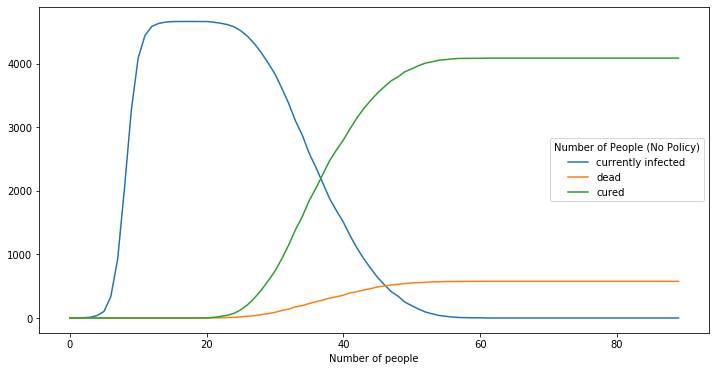

In [349]:
plt.figure(figsize=(12, 6))
plt.plot(track_current_infection)
plt.plot(track_deaths)
plt.plot(track_cured)
plt.xlabel('Days')
plt.xlabel('Number of people')
plt.legend(labels=['currently infected','dead', 'cured'], title='Number of People (No Policy)')
plt.show()

# Compare Different Age Groups

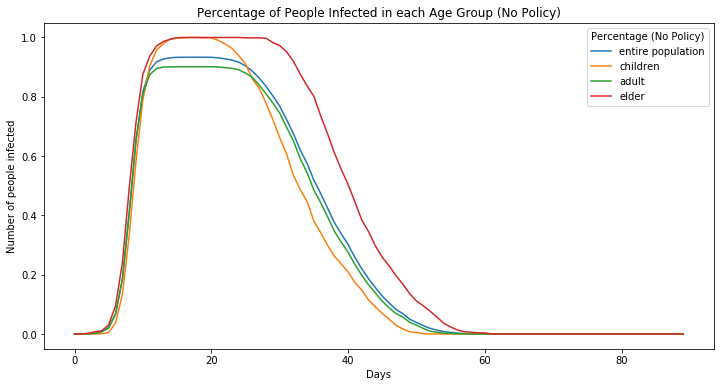

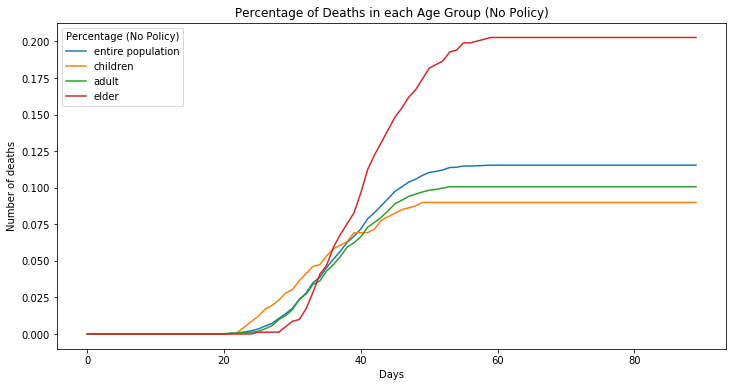

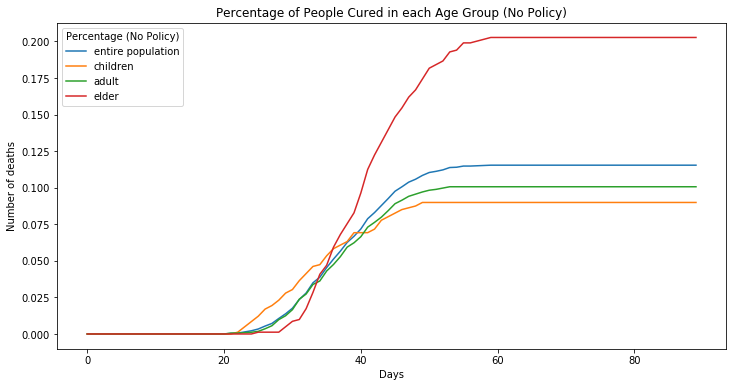

In [350]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(track_current_infection)/populations)
plt.plot(np.array(track_current_infection_children)/n_children)
plt.plot(np.array(track_current_infection_adult)/n_adults)
plt.plot(np.array(track_current_infection_elder)/n_elders)
plt.title('Percentage of People Infected in each Age Group (No Policy)')
plt.xlabel('Days')
plt.ylabel('Number of people infected')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (No Policy)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_deaths)/populations)
plt.plot(np.array(track_deaths_children)/n_children)
plt.plot(np.array(track_deaths_adult)/n_adults)
plt.plot(np.array(track_deaths_elder)/n_elders)
plt.title('Percentage of Deaths in each Age Group (No Policy)')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (No Policy)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_deaths)/populations)
plt.plot(np.array(track_deaths_children)/n_children)
plt.plot(np.array(track_deaths_adult)/n_adults)
plt.plot(np.array(track_deaths_elder)/n_elders)
plt.title('Percentage of People Cured in each Age Group (No Policy)')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (No Policy)')
plt.show()

## Policy 1: Social Distancing
## - The amount of social interactions reduced at all places
## - Thus the infection rates for all age groups decrease

In [351]:
interaction_rate_choices = {'office':0.05, 'school':0.05, 'store':0.05, 'restaurant':0.05}
infection_prob_choices = {'children':0.05, 'adult1':0.05, 'adult2':0,'elder':0.05}

np.random.seed(seed)

# individual status vectors with the lengths equal the entire population
dead = np.zeros(populations)
cured = np.zeros(populations)
incubation = np.zeros(populations)
symptom = np.zeros(populations)
infected = np.zeros(populations)

incubation_progress_day = np.zeros(populations)
symptom_progress_day = np.zeros(populations)

office = np.zeros(populations)
school = np.zeros(populations)

# simulate which office to go to for each adult
office[(age_groups == 'adult1') | (age_groups == 'adult2')] = np.random.choice(a=office_labels, size=n_adults)
# simulate which school to go to for each child
school[age_groups == 'children'] = np.random.choice(a=school_labels, size=n_children)

# simulate patient zero 
patient_zero_index = np.random.randint(0, populations-1)
infected[patient_zero_index] = 1
incubation[patient_zero_index] = 1
print(f'Patient Zero id: {patient_zero_index}')
print(get_profile(patient_zero_index))

Patient Zero id: 4371
{'infected': 1.0, 'incubation': 1.0, 'symptom': 0.0, 'age_groups': 'adult1', 'dead': 0.0, 'cured': 0.0}


In [352]:
track_current_infection_p1 = []
track_deaths_p1 = []
track_cured_p1 = []

track_current_infection_children_p1 = []
track_deaths_children_p1 = []
track_cured_children_p1 = []

track_current_infection_adult_p1 = []
track_deaths_adult_p1 = []
track_cured_adult_p1 = []

track_current_infection_elder_p1 = []
track_deaths_elder_p1 = []
track_cured_elder_p1 = []



np.random.seed(seed)

for day in range(1, days+1):
    #print(f'Day {day}\n')
    #print(f'Number of current infection: {np.count_nonzero(infected==1)}\n')
    #print(f'Number of people in incubation :{np.count_nonzero(incubation==1)}\n')
    #print(f'Number of people with symptoms :{np.count_nonzero(symptom==1)}\n')
    #print(f'Number of deaths: {np.count_nonzero(dead==1)}\n')
    #print(f'Number of cured: {np.count_nonzero(cured==1)}\n')
    
    track_current_infection_p1.append(np.count_nonzero(infected==1))
    track_deaths_p1.append(np.count_nonzero(dead==1))
    track_cured_p1.append(np.count_nonzero(cured==1))
    
    track_current_infection_children_p1.append(np.count_nonzero((infected==1) & (age_groups=='children')))
    track_deaths_children_p1.append(np.count_nonzero((dead==1) & (age_groups=='children')))
    track_cured_children_p1.append(np.count_nonzero((cured==1) & (age_groups=='children')))

    track_current_infection_adult_p1.append(np.count_nonzero((infected==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_deaths_adult_p1.append(np.count_nonzero((dead==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_cured_adult_p1.append(np.count_nonzero((cured==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))

    track_current_infection_elder_p1.append(np.count_nonzero((infected==1) & (age_groups=='elder')))
    track_deaths_elder_p1.append(np.count_nonzero((dead==1) & (age_groups=='elder')))
    track_cured_elder_p1.append(np.count_nonzero((cured==1) & (age_groups=='elder')))
    
    store = np.zeros(populations)
    restaurant = np.zeros(populations)
    #assert len(store[(age_groups=='adult') & (age_groups=='elder')]) == n_adults+n_elders, 'length mismatch'
    store[(age_groups=='adult1') | (age_groups=='adult2') | (age_groups=='elder')] = np.random.choice(a=[i for i in range(n_stores+1)],
                                                                            p=prob_stores,
                                                                           size=n_adults+n_elders)
    
    restaurant = np.random.choice(a=[i for i in range(n_restaurants+1)],
                                  p=prob_restaurants,
                                  size=populations)
    
    for o in office_labels:
        actual_interactions = interact(id_list=np.nonzero((office==o) & (dead==0))[0], scenario='office',
                                       label=o, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Office{o}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    for s in school_labels:
        actual_interactions = interact(id_list=np.nonzero((school==s) & (dead==0))[0], scenario='school',
                                       label=s, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in School{s}\n')
            continue
        infect(actual_interactions, verbose=False)
     
    for t in store_labels:
        actual_interactions = interact(id_list=np.nonzero((store==t) & (dead==0))[0], scenario='store',
                                       label=t, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Store{t}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    for r in restaurant_labels:
        actual_interactions = interact(id_list=np.nonzero((restaurant==r) & (dead==0))[0], scenario='restaurant',
                                       label=r, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Restaurant{r}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    incubation_progress_update()
    symptom_progress_update()
    start_symptom(incubation_periods)
    start_judgement(symptom_periods)

## Policy 2: Self-Isolation if have symptoms
## - People who developed symptoms will stay at home. Only grocery shopping is allowed. 

In [353]:
infection_prob_choices = {'children':0.06, 'adult1':0.05, 'adult2':0,'elder':0.1}
interaction_rate_choices = {'office':0.1, 'school':0.1, 'store':0.05, 'restaurant':0.1}

np.random.seed(seed)

# individual status vectors with the lengths equal the entire population
dead = np.zeros(populations)
cured = np.zeros(populations)
incubation = np.zeros(populations)
symptom = np.zeros(populations)
infected = np.zeros(populations)

incubation_progress_day = np.zeros(populations)
symptom_progress_day = np.zeros(populations)

office = np.zeros(populations)
school = np.zeros(populations)

# simulate which office to go to for each adult
office[(age_groups == 'adult1') | (age_groups == 'adult2')] = np.random.choice(a=office_labels, size=n_adults)
# simulate which school to go to for each child
school[age_groups == 'children'] = np.random.choice(a=school_labels, size=n_children)

# simulate patient zero 
patient_zero_index = np.random.randint(0, populations-1)
infected[patient_zero_index] = 1
incubation[patient_zero_index] = 1
print(f'Patient Zero id: {patient_zero_index}')
print(get_profile(patient_zero_index))

Patient Zero id: 4371
{'infected': 1.0, 'incubation': 1.0, 'symptom': 0.0, 'age_groups': 'adult1', 'dead': 0.0, 'cured': 0.0}


In [354]:
track_current_infection_p2 = []
track_deaths_p2 = []
track_cured_p2 = []

track_current_infection_children_p2 = []
track_deaths_children_p2 = []
track_cured_children_p2 = []

track_current_infection_adult_p2 = []
track_deaths_adult_p2 = []
track_cured_adult_p2 = []

track_current_infection_elder_p2 = []
track_deaths_elder_p2 = []
track_cured_elder_p2 = []


np.random.seed(seed)

for day in range(1, days+1):
    #print(f'Day {day}\n')
    #print(f'Number of current infection: {np.count_nonzero(infected==1)}\n')
    #print(f'Number of people in incubation :{np.count_nonzero(incubation==1)}\n')
    #print(f'Number of people with symptoms :{np.count_nonzero(symptom==1)}\n')
    #print(f'Number of deaths: {np.count_nonzero(dead==1)}\n')
    #print(f'Number of cured: {np.count_nonzero(cured==1)}\n')
    
    track_current_infection_p2.append(np.count_nonzero(infected==1))
    track_deaths_p2.append(np.count_nonzero(dead==1))
    track_cured_p2.append(np.count_nonzero(cured==1))
    
    track_current_infection_children_p2.append(np.count_nonzero((infected==1) & (age_groups=='children')))
    track_deaths_children_p2.append(np.count_nonzero((dead==1) & (age_groups=='children')))
    track_cured_children_p2.append(np.count_nonzero((cured==1) & (age_groups=='children')))

    track_current_infection_adult_p2.append(np.count_nonzero((infected==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_deaths_adult_p2.append(np.count_nonzero((dead==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_cured_adult_p2.append(np.count_nonzero((cured==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))

    track_current_infection_elder_p2.append(np.count_nonzero((infected==1) & (age_groups=='elder')))
    track_deaths_elder_p2.append(np.count_nonzero((dead==1) & (age_groups=='elder')))
    track_cured_elder_p2.append(np.count_nonzero((cured==1) & (age_groups=='elder')))
    
    store = np.zeros(populations)
    restaurant = np.zeros(populations)
    #assert len(store[(age_groups=='adult') & (age_groups=='elder')]) == n_adults+n_elders, 'length mismatch'
    store[(age_groups=='adult1') | (age_groups=='adult2') | (age_groups=='elder')] = np.random.choice(a=[i for i in range(n_stores+1)],
                                                                            p=prob_stores,
                                                                           size=n_adults+n_elders)
    
    restaurant = np.random.choice(a=[i for i in range(n_restaurants+1)],
                                  p=prob_restaurants,
                                  size=populations)
    
    for o in office_labels:
        actual_interactions = interact(id_list=np.nonzero((office==o) & (symptom==0) & (dead==0))[0], scenario='office',
                                       label=o, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Office{o}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    for s in school_labels:
        actual_interactions = interact(id_list=np.nonzero((school==s) & (symptom==0) & (dead==0))[0], scenario='school',
                                       label=s, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in School{s}\n')
            continue
        infect(actual_interactions, verbose=False)
     
    for t in store_labels:
        actual_interactions = interact(id_list=np.nonzero((store==t) & (dead==0))[0], scenario='store',
                                       label=t, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Store{t}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    for r in restaurant_labels:
        actual_interactions = interact(id_list=np.nonzero((restaurant==r) & (symptom==0) & (dead==0))[0], scenario='restaurant',
                                       label=r, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Restaurant{r}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    incubation_progress_update()
    symptom_progress_update()
    start_symptom(incubation_periods)
    start_judgement(symptom_periods)

Less than 2 people left in school6
Infection is impossible in School6

Less than 2 people left in school2
Infection is impossible in School2

Less than 2 people left in school6
Infection is impossible in School6

Less than 2 people left in school2
Infection is impossible in School2

Less than 2 people left in school6
Infection is impossible in School6

Less than 2 people left in school6
Infection is impossible in School6

Less than 2 people left in school6
Infection is impossible in School6



## Policy 3: Shut down Offices Schools and Restaurants
## - Schools, offices and restaurants are shut down. Only grocery stores are open. 
## - Note no social distancing is implemented in ths case

In [355]:
infection_prob_choices = {'children':0.06, 'adult1':0.05, 'adult2':0,'elder':0.1}
interaction_rate_choices = {'office':0.1, 'school':0.1, 'store':0.05, 'restaurant':0.1}

np.random.seed(seed)

# individual status vectors with the lengths equal the entire population
dead = np.zeros(populations)
cured = np.zeros(populations)
incubation = np.zeros(populations)
symptom = np.zeros(populations)
infected = np.zeros(populations)

incubation_progress_day = np.zeros(populations)
symptom_progress_day = np.zeros(populations)

office = np.zeros(populations)
school = np.zeros(populations)

# simulate which office to go to for each adult
office[(age_groups == 'adult1') | (age_groups == 'adult2')] = np.random.choice(a=office_labels, size=n_adults)
# simulate which school to go to for each child
school[age_groups == 'children'] = np.random.choice(a=school_labels, size=n_children)

# simulate patient zero 
patient_zero_index = np.random.randint(0, populations-1)
infected[patient_zero_index] = 1
incubation[patient_zero_index] = 1
print(f'Patient Zero id: {patient_zero_index}')
print(get_profile(patient_zero_index))

Patient Zero id: 4371
{'infected': 1.0, 'incubation': 1.0, 'symptom': 0.0, 'age_groups': 'adult1', 'dead': 0.0, 'cured': 0.0}


In [356]:
track_current_infection_p3 = []
track_deaths_p3 = []
track_cured_p3 = []

track_current_infection_children_p3 = []
track_deaths_children_p3 = []
track_cured_children_p3 = []

track_current_infection_adult_p3 = []
track_deaths_adult_p3 = []
track_cured_adult_p3 = []

track_current_infection_elder_p3 = []
track_deaths_elder_p3 = []
track_cured_elder_p3 = []


np.random.seed(seed)

for day in range(1, days+1):
    #print(f'Day {day}\n')
    #print(f'Number of current infection: {np.count_nonzero(infected==1)}\n')
    #print(f'Number of people in incubation :{np.count_nonzero(incubation==1)}\n')
    #print(f'Number of people with symptoms :{np.count_nonzero(symptom==1)}\n')
    #print(f'Number of deaths: {np.count_nonzero(dead==1)}\n')
    #print(f'Number of cured: {np.count_nonzero(cured==1)}\n')
    
    track_current_infection_p3.append(np.count_nonzero(infected==1))
    track_deaths_p3.append(np.count_nonzero(dead==1))
    track_cured_p3.append(np.count_nonzero(cured==1))
    
    track_current_infection_children_p3.append(np.count_nonzero((infected==1) & (age_groups=='children')))
    track_deaths_children_p3.append(np.count_nonzero((dead==1) & (age_groups=='children')))
    track_cured_children_p3.append(np.count_nonzero((cured==1) & (age_groups=='children')))

    track_current_infection_adult_p3.append(np.count_nonzero((infected==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_deaths_adult_p3.append(np.count_nonzero((dead==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_cured_adult_p3.append(np.count_nonzero((cured==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))

    track_current_infection_elder_p3.append(np.count_nonzero((infected==1) & (age_groups=='elder')))
    track_deaths_elder_p3.append(np.count_nonzero((dead==1) & (age_groups=='elder')))
    track_cured_elder_p3.append(np.count_nonzero((cured==1) & (age_groups=='elder')))
    
    store = np.zeros(populations)
    #restaurant = np.zeros(populations)
    #assert len(store[(age_groups=='adult') & (age_groups=='elder')]) == n_adults+n_elders, 'length mismatch'
    store[(age_groups=='adult1') | (age_groups=='adult2') | (age_groups=='elder')] = np.random.choice(a=[i for i in range(n_stores+1)],
                                                                            p=prob_stores,
                                                                           size=n_adults+n_elders)
    
    
    for t in store_labels:
        actual_interactions = interact(id_list=np.nonzero((store==t) & (dead==0))[0], scenario='store',
                                       label=t, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Store{t}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    
    incubation_progress_update()
    symptom_progress_update()
    start_symptom(incubation_periods)
    start_judgement(symptom_periods)

# Policy 4: Combination of policy 1 and 3 (more realistic)
# - Social Distancing
# - Shut down school, offices, and restaruants

In [357]:
interaction_rate_choices = {'office':0.05, 'school':0.05, 'store':0.05, 'restaurant':0.05}
infection_prob_choices = {'children':0.05, 'adult1':0.05, 'adult2':0,'elder':0.05}

np.random.seed(seed)

# individual status vectors with the lengths equal the entire population
dead = np.zeros(populations)
cured = np.zeros(populations)
incubation = np.zeros(populations)
symptom = np.zeros(populations)
infected = np.zeros(populations)

incubation_progress_day = np.zeros(populations)
symptom_progress_day = np.zeros(populations)

office = np.zeros(populations)
school = np.zeros(populations)

# simulate which office to go to for each adult
office[(age_groups == 'adult1') | (age_groups == 'adult2')] = np.random.choice(a=office_labels, size=n_adults)
# simulate which school to go to for each child
school[age_groups == 'children'] = np.random.choice(a=school_labels, size=n_children)

# simulate patient zero 
patient_zero_index = np.random.randint(0, populations-1)
infected[patient_zero_index] = 1
incubation[patient_zero_index] = 1
print(f'Patient Zero id: {patient_zero_index}')
print(get_profile(patient_zero_index))

Patient Zero id: 4371
{'infected': 1.0, 'incubation': 1.0, 'symptom': 0.0, 'age_groups': 'adult1', 'dead': 0.0, 'cured': 0.0}


In [358]:
track_current_infection_p4 = []
track_deaths_p4 = []
track_cured_p4 = []

track_current_infection_children_p4 = []
track_deaths_children_p4 = []
track_cured_children_p4 = []

track_current_infection_adult_p4 = []
track_deaths_adult_p4 = []
track_cured_adult_p4 = []

track_current_infection_elder_p4 = []
track_deaths_elder_p4 = []
track_cured_elder_p4 = []



np.random.seed(seed)
for day in range(1, days+1):
    #print(f'Day {day}\n')
    #print(f'Number of current infection: {np.count_nonzero(infected==1)}\n')
    #print(f'Number of people in incubation :{np.count_nonzero(incubation==1)}\n')
    #print(f'Number of people with symptoms :{np.count_nonzero(symptom==1)}\n')
    #print(f'Number of deaths: {np.count_nonzero(dead==1)}\n')
    #print(f'Number of cured: {np.count_nonzero(cured==1)}\n')
    
    track_current_infection_p4.append(np.count_nonzero(infected==1))
    track_deaths_p4.append(np.count_nonzero(dead==1))
    track_cured_p4.append(np.count_nonzero(cured==1))
    
    track_current_infection_children_p4.append(np.count_nonzero((infected==1) & (age_groups=='children')))
    track_deaths_children_p4.append(np.count_nonzero((dead==1) & (age_groups=='children')))
    track_cured_children_p4.append(np.count_nonzero((cured==1) & (age_groups=='children')))

    track_current_infection_adult_p4.append(np.count_nonzero((infected==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_deaths_adult_p4.append(np.count_nonzero((dead==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))
    track_cured_adult_p4.append(np.count_nonzero((cured==1) & ((age_groups=='adult1') | (age_groups=='adult2'))))

    track_current_infection_elder_p4.append(np.count_nonzero((infected==1) & (age_groups=='elder')))
    track_deaths_elder_p4.append(np.count_nonzero((dead==1) & (age_groups=='elder')))
    track_cured_elder_p4.append(np.count_nonzero((cured==1) & (age_groups=='elder')))
    
    store = np.zeros(populations)
    #restaurant = np.zeros(populations)
    #assert len(store[(age_groups=='adult') & (age_groups=='elder')]) == n_adults+n_elders, 'length mismatch'
    store[(age_groups=='adult1') | (age_groups=='adult2') | (age_groups=='elder')] = np.random.choice(a=[i for i in range(n_stores+1)],
                                                                            p=prob_stores,
                                                                           size=n_adults+n_elders)
    

    for t in store_labels:
        actual_interactions = interact(id_list=np.nonzero((store==t) & (dead==0))[0], scenario='store',
                                       label=t, verbose=False, interaction_rate_choices=interaction_rate_choices)
        if actual_interactions == None:
            print(f'Infection is impossible in Store{t}\n')
            continue
        infect(actual_interactions, verbose=False)
    
    
    incubation_progress_update()
    symptom_progress_update()
    start_symptom(incubation_periods)
    start_judgement(symptom_periods)

# Compare policies

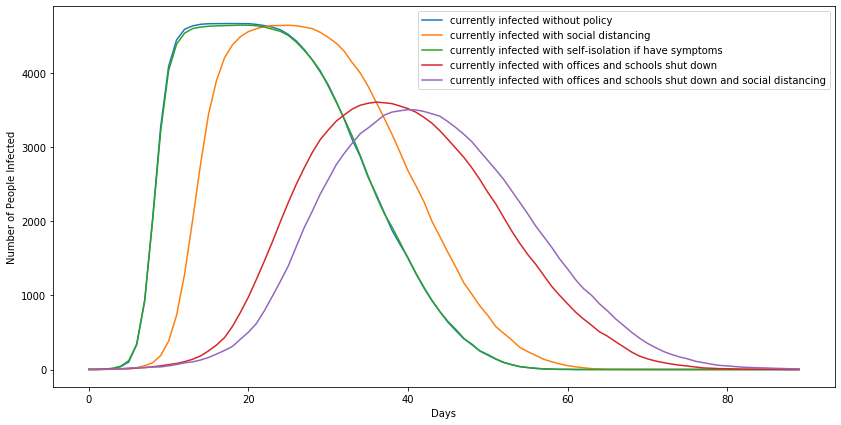

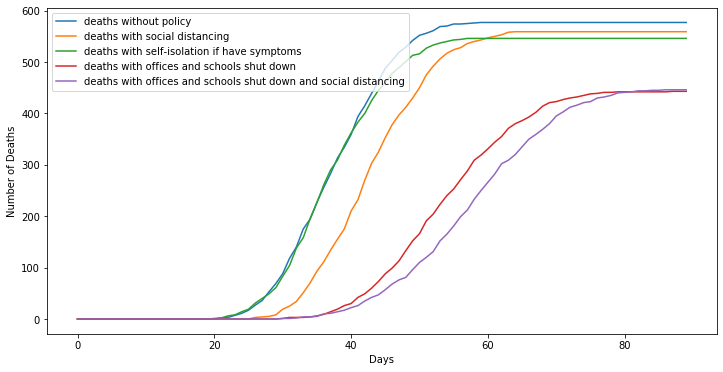

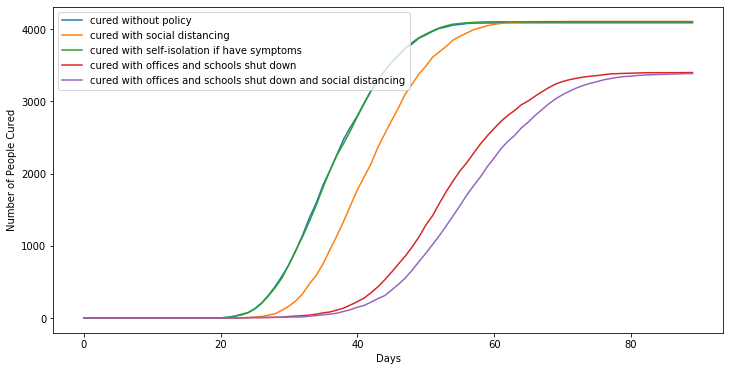

In [359]:
plt.figure(figsize=(14, 7))
plt.plot(track_current_infection)
plt.plot(track_current_infection_p1)
plt.plot(track_current_infection_p2)
plt.plot(track_current_infection_p3)
plt.plot(track_current_infection_p4)
plt.xlabel('Days')
plt.ylabel('Number of People Infected')
plt.legend(labels=['currently infected without policy',
                   'currently infected with social distancing', 
                   'currently infected with self-isolation if have symptoms',
                   'currently infected with offices and schools shut down', 
                   'currently infected with offices and schools shut down and social distancing'])
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(track_deaths)
plt.plot(track_deaths_p1)
plt.plot(track_deaths_p2)
plt.plot(track_deaths_p3)
plt.plot(track_deaths_p4)
plt.xlabel('Days')
plt.ylabel('Number of Deaths')
plt.legend(labels=['deaths without policy',
                   'deaths with social distancing', 
                   'deaths with self-isolation if have symptoms',
                   'deaths with offices and schools shut down',
                   'deaths with offices and schools shut down and social distancing'])
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(track_cured)
plt.plot(track_cured_p1)
plt.plot(track_cured_p2)
plt.plot(track_cured_p3)
plt.plot(track_cured_p4)
plt.xlabel('Days')
plt.ylabel('Number of People Cured')
plt.legend(labels=['cured without policy',
                   'cured with social distancing', 
                   'cured with self-isolation if have symptoms',
                   'cured with offices and schools shut down',
                   'cured with offices and schools shut down and social distancing',
                   ])
plt.show()

# Compare Age Groups under different policies

# Policy 1

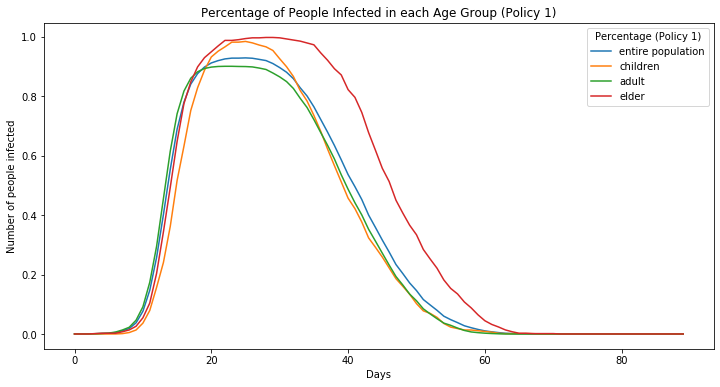

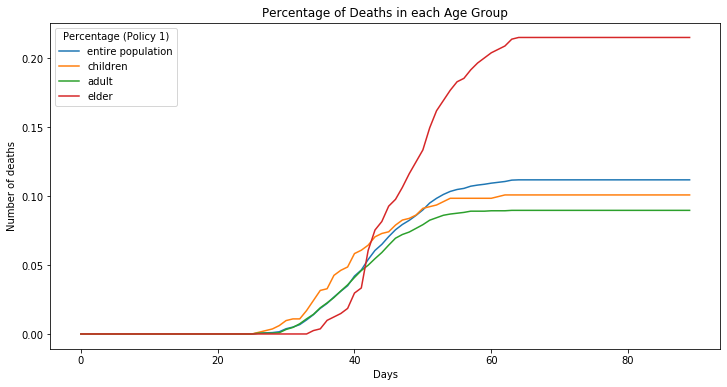

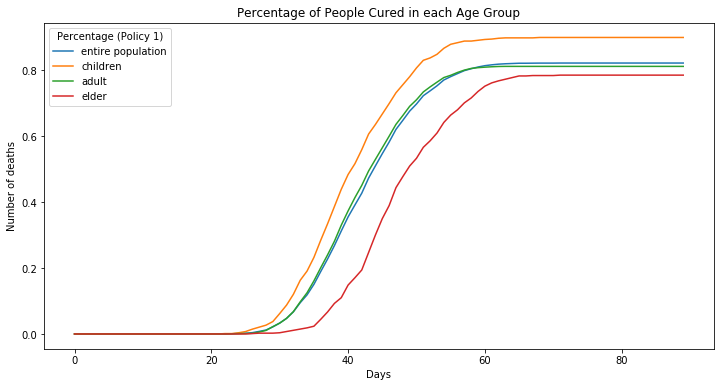

In [364]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(track_current_infection_p1)/populations)
plt.plot(np.array(track_current_infection_children_p1)/n_children)
plt.plot(np.array(track_current_infection_adult_p1)/n_adults)
plt.plot(np.array(track_current_infection_elder_p1)/n_elders)
plt.title('Percentage of People Infected in each Age Group (Policy 1)')
plt.xlabel('Days')
plt.ylabel('Number of people infected')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 1)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_deaths_p1)/populations)
plt.plot(np.array(track_deaths_children_p1)/n_children)
plt.plot(np.array(track_deaths_adult_p1)/n_adults)
plt.plot(np.array(track_deaths_elder_p1)/n_elders)
plt.title('Percentage of Deaths in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 1)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_cured_p1)/populations)
plt.plot(np.array(track_cured_children_p1)/n_children)
plt.plot(np.array(track_cured_adult_p1)/n_adults)
plt.plot(np.array(track_cured_elder_p1)/n_elders)
plt.title('Percentage of People Cured in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 1)')
plt.show()

# Policy 2

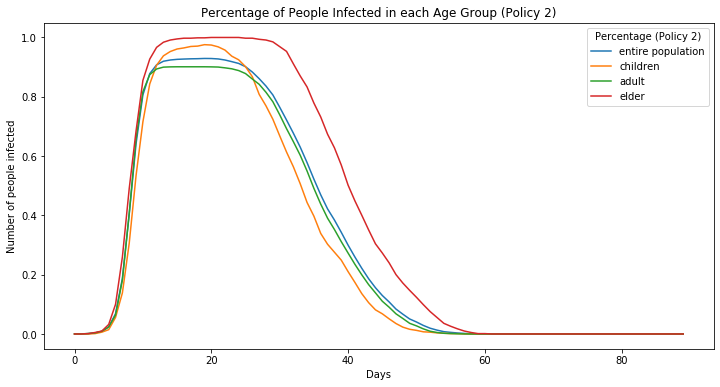

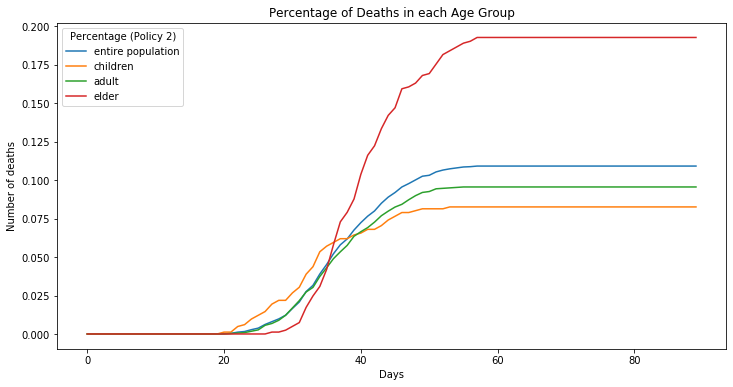

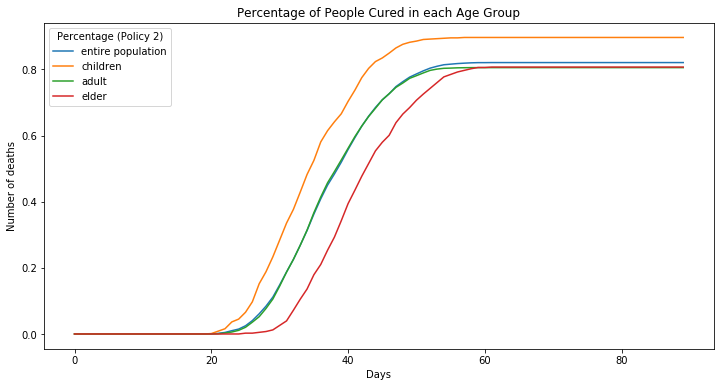

In [365]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(track_current_infection_p2)/populations)
plt.plot(np.array(track_current_infection_children_p2)/n_children)
plt.plot(np.array(track_current_infection_adult_p2)/n_adults)
plt.plot(np.array(track_current_infection_elder_p2)/n_elders)
plt.title('Percentage of People Infected in each Age Group (Policy 2)')
plt.xlabel('Days')
plt.ylabel('Number of people infected')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 2)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_deaths_p2)/populations)
plt.plot(np.array(track_deaths_children_p2)/n_children)
plt.plot(np.array(track_deaths_adult_p2)/n_adults)
plt.plot(np.array(track_deaths_elder_p2)/n_elders)
plt.title('Percentage of Deaths in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 2)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_cured_p2)/populations)
plt.plot(np.array(track_cured_children_p2)/n_children)
plt.plot(np.array(track_cured_adult_p2)/n_adults)
plt.plot(np.array(track_cured_elder_p2)/n_elders)
plt.title('Percentage of People Cured in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 2)')
plt.show()

# Policy 3

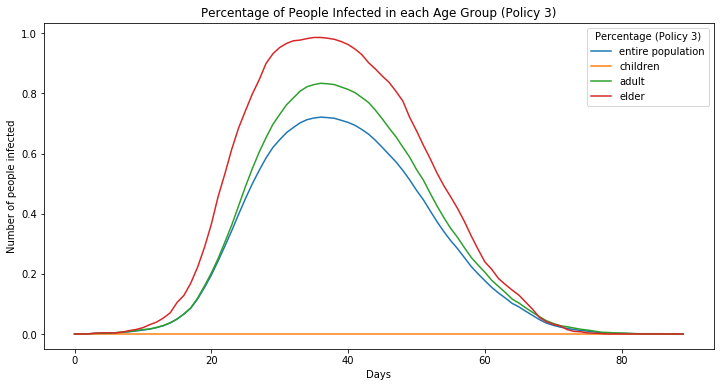

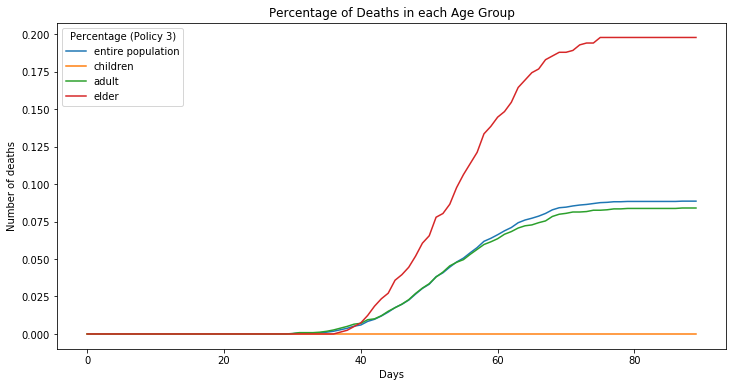

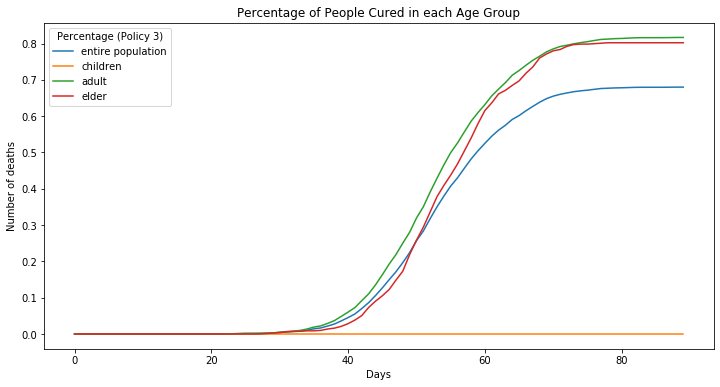

In [366]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(track_current_infection_p3)/populations)
plt.plot(np.array(track_current_infection_children_p3)/n_children)
plt.plot(np.array(track_current_infection_adult_p3)/n_adults)
plt.plot(np.array(track_current_infection_elder_p3)/n_elders)
plt.title('Percentage of People Infected in each Age Group (Policy 3)')
plt.xlabel('Days')
plt.ylabel('Number of people infected')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 3)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_deaths_p3)/populations)
plt.plot(np.array(track_deaths_children_p3)/n_children)
plt.plot(np.array(track_deaths_adult_p3)/n_adults)
plt.plot(np.array(track_deaths_elder_p3)/n_elders)
plt.title('Percentage of Deaths in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 3)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_cured_p3)/populations)
plt.plot(np.array(track_cured_children_p3)/n_children)
plt.plot(np.array(track_cured_adult_p3)/n_adults)
plt.plot(np.array(track_cured_elder_p3)/n_elders)
plt.title('Percentage of People Cured in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 3)')
plt.show()

# Policy 4

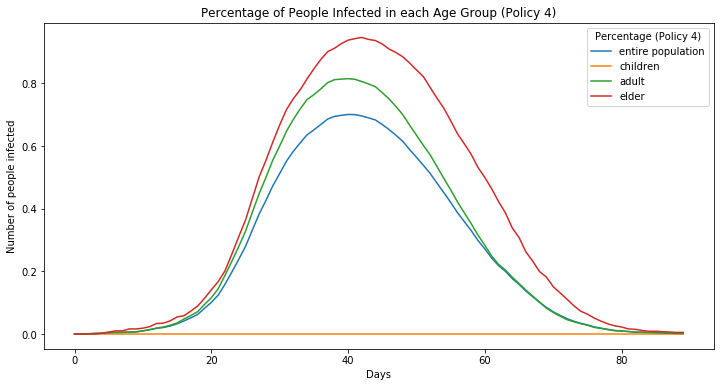

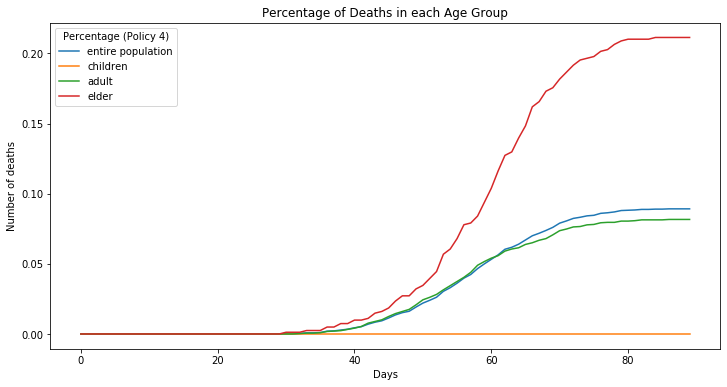

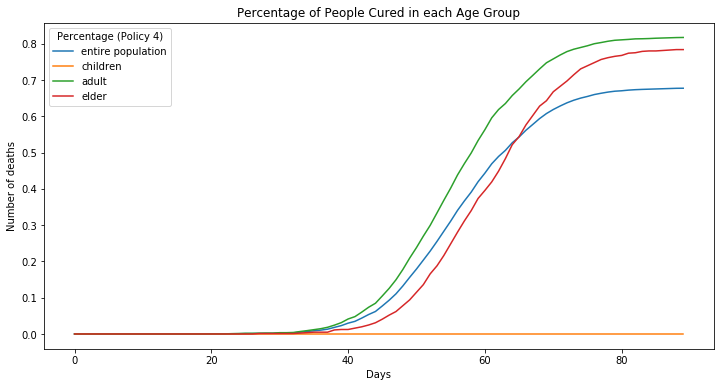

In [367]:
plt.figure(figsize=(12, 6))
plt.plot(np.array(track_current_infection_p4)/populations)
plt.plot(np.array(track_current_infection_children_p4)/n_children)
plt.plot(np.array(track_current_infection_adult_p4)/n_adults)
plt.plot(np.array(track_current_infection_elder_p4)/n_elders)
plt.title('Percentage of People Infected in each Age Group (Policy 4)')
plt.xlabel('Days')
plt.ylabel('Number of people infected')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 4)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_deaths_p4)/populations)
plt.plot(np.array(track_deaths_children_p4)/n_children)
plt.plot(np.array(track_deaths_adult_p4)/n_adults)
plt.plot(np.array(track_deaths_elder_p4)/n_elders)
plt.title('Percentage of Deaths in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 4)')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(np.array(track_cured_p4)/populations)
plt.plot(np.array(track_cured_children_p4)/n_children)
plt.plot(np.array(track_cured_adult_p4)/n_adults)
plt.plot(np.array(track_cured_elder_p4)/n_elders)
plt.title('Percentage of People Cured in each Age Group')
plt.xlabel('Days')
plt.ylabel('Number of deaths')
plt.legend(labels=['entire population','children', 'adult', 'elder'], title='Percentage (Policy 4)')
plt.show()